## Step 1: Import some packages 

As in often the case, we start our code by importing some Python modules. 

In this case, we import the objects module which holds a number of helper function that I prepared.

In [1]:
# 'objects' module has code that I wrote to analyze this dataset
import objects
# matplotlib.pyplot module has functions for plotting, note that we are importing it as plt
import matplotlib.pyplot as plt

## Step 2: Get the data from Open Science Foundation
The data files are shared in an public repository at the [Open Science Foundation](https://osf.io/bwntz/]). 

The code below calls a function

    objects.fetch_data()

that grabs the data and makes it accessible to the current workbook. 

If you inspect the function (look under "fetch_data" in objects.py) you will notice the structure of the code

    !osf --project bwntz clone
    
- "!" indicates that this we are running something from the command line, outside Python.
- "bwntz" is the ID of the project on OSF.
- "clone" simply means we want to make a local copy of the files from OSF

The command will place the files in the local folder 

    bwntz/osfstorage/data
    
which is where we grab the data from in the next step. The code also checks if files have already been downloaded, and if they have, it will not waste time redownloading.

A limitation that I am still trying to work out is that you cannot specify a subset files that you want to grab, you have to get the whole thing.

In [2]:
objects.fetch_data("bwntz")

data already exists, not downloading


## Step 3: Load and organize the data from each participant

The code below loads in the individual data files in csv format that each participant, including you, created when they did the experiment. When running an experiment online, you would normally have some sort of back-end that saves the files automatically somewhere, so you do not have to trust your participant to send you the raw data.

In [3]:
data_dir = "bwntz/osfstorage/data"
exp_n = 199
labels = ['bear','elephant','person','car','dog','apple','chair','plane','bird','zebra']
all_data, sub_info = objects.load_data(data_dir, exp_n, labels)

0 0000 duplicate participants, skipping the second file


## Step 4: Average confusion matrices and accuracies over participants
You may re-run this code after removing subjects from all_conf and all_corr that more than two standard errors away from the mean. 

In [4]:
mean_conf, mean_corr, all_corr = objects.confusion_averages(all_data)

/Users/pjkohler/code/git/teaching/NRSC2200/pphys_object-recognition/objects.py:164: RuntimeWarning: Mean of empty slice
  mean_conf = np.nanmean(all_conf, 0)


## Step 5: Plot accuracies for each image pair
Now we will plot the accuracies for each image pair. We will use the values from the confusion matrix, but convert them into a list. 

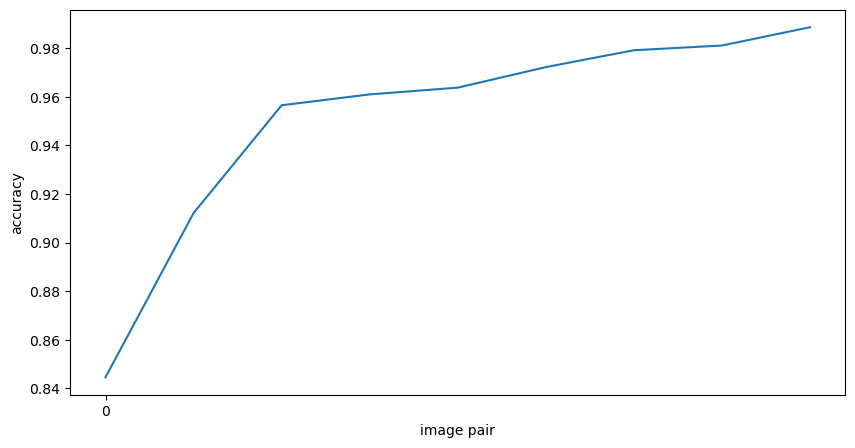

In [5]:
conf_list, label_list = objects.confusion_list(mean_conf, labels)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(conf_list)
ax.set_xticks(range(0,len(label_list)+1,10))
#ax.set_xticklabels(label_list[0:10:],rotation = 45, ha="center")
plt.xlabel("image pair")
plt.ylabel("accuracy")
plt.show()

## Step 6: Create a confusion matrix
The code below makes a confusion matrix. Each cell reflects the proportion of trials where the non-target image (distractor) was chosen for each image pair. Since the target and distractor were always different, the diagonal is colored white and marked with "NA". 

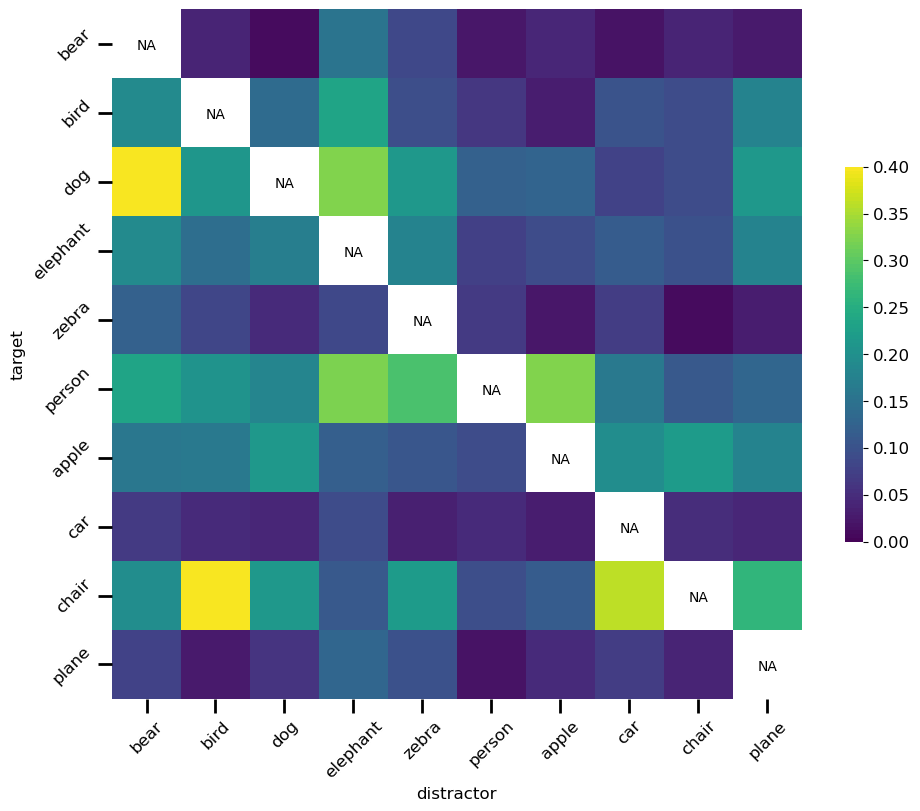

In [6]:
# reorder the labels to reveal category-specific confusion
new_labels = ['bear','bird','dog','elephant','zebra','person','apple','car','chair','plane']
plt = objects.confusion_plot(mean_conf, labels, new_labels)
plt.show()

## Assignment 4

### Question 1 (4 pts)

In the previous assignment you identified outlier timepoints. In some cases, it may be similarly useful to identify outlier participants. This is especially true for behavioral experiments that are collected online, where you may have participants that do not understand the task, or simply decide not to do it. Here we will identify participants whose overall accuracy is substantially lower than the mean. Write and share code to do the following:

(a) Based on all *all_corr*, create a variable that has *True* for any participant whose accuracy is more than 2 standard errors **lower** than the mean, and *False* otherwise. 

(b) Use logical indexing to remove those participants from *all_conf* and *all_corr* and recompute the overall average accuracy and overall average confusion matrix. 

(c) Use the recomputed average to plot the confusion matrix and share - this can be done by re-running **Step 6** with your recomputed average confusion matrix.

(d) Use the variable *exp_subs* to identify the participants that were rejected.


In [7]:
# work on your answer here

### Question 2 (2 pts)

One of key points of the experiment and the paper *Simple Learned Weighted Sums of Inferior Temporal Neuronal Firing Rates Accurately Predict Human Core Object Recognition Performance* by Majaj and colleagues (2015), is that some objects are more difficult to distinguish than others. Here we will identify those objects.

(a) Pay attention **Step 5: Plot accuracies for each image pair**. Note that the variable *conf_list* is a sorted list of accuracies for each image pair. Also note that *label_list* is a matched list of image pair labels in the format "tt_vs_dd" where tt is the target and dd is the distractor. Use these variables to identify the image pairs with the lowest and highest average accuracy, i.e. the distractors that were easiest and most difficult to distinguish from the targets. Share your code, and the resulting image pairs.

(b) Find the image pairs you identified in the confusion matrix plotted in **Step 6**. Are your findings consistent with the confusion matrix? Explain why.

In [8]:
# work on your answer here:

### Question 3 (4 pts)

It is often informative to establish the consistency of your measurement across participants. Here we will do something like this, by computing the split-half correlation across participants. Write and share code that does the following: 

(a) *all_conf* holds the confusion matrices for each participant. It is a n x 10 x 10 matrix, where n is the remaining number of subjects after removing outlier participants in **Question 1**. Compute two average confusion matrices: One over the first half of participants and one over the second half. Because the confusion matrices contain missing values, NaNs, you have to use the command np.nanmean to compute the averages.

(b) Use the command np.corrcoef to compute Pearson correlations between your two split-half averages. Your averages will also contain NaNs, so you have to remove them from your averages before applying np.corrcoef. Assuming your average is stored in variable c1, this can be done with the following code:  

    c1[~np.isnan(c1)]
    
(c) np.corrcoef returns a 2 x 2 matrix, the Pearson correlation is the values that are not equal to 1. Write code to print your correlation.

(d) In the Majaj paper the median correlation across human participants in a similar task was 0.929. Why do you think we did worse?

In [9]:
# work on your answer here: